Once again, we bring in the necessary libraries, bring out the columns for the dataset and preprocess them through encoding, splitting and creating the required tensors.

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib

cols = [f'feature_{i}' for i in range(41)] + ['label', 'difficulty']
df = pd.read_csv("KDDTrain+.txt", header=None, names=cols)

label_encoders = {}

# Encoding of categorical featuers to numerical values
for col in ['feature_1', 'feature_2', 'feature_3']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save encoders
joblib.dump(label_encoders, "label_encoders.pkl")

# Binary filtering
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Normal split for training
df_normal = df[df['label'] == 0]
X_normal = df_normal.iloc[:, :-2].values  # exclude label and difficulty
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Save the scaler for deployment
joblib.dump(scaler, "scaler.pkl") 

# load the Dataset
class KDDDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]


Here the Autoencoder architecture is defined, with some layer definitions similar to the MLP before, but with separate encoder and decoder structures. The model is trained with different hyperparameters to account for the different architecture, but with the same epochs.

In [15]:
train_loader = DataLoader(KDDDataset(X_normal_scaled), batch_size=64, shuffle=True)

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training
model = Autoencoder(input_dim=X_normal_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(30):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")
    
    torch.save(model.state_dict(), "autoencoder.pth")


Epoch 1: Loss = 565.0578
Epoch 2: Loss = 383.6122
Epoch 3: Loss = 334.7362
Epoch 4: Loss = 300.4106
Epoch 5: Loss = 273.1934
Epoch 6: Loss = 259.6165
Epoch 7: Loss = 240.5221
Epoch 8: Loss = 227.8049
Epoch 9: Loss = 214.4291
Epoch 10: Loss = 200.6379
Epoch 11: Loss = 202.8242
Epoch 12: Loss = 187.6722
Epoch 13: Loss = 183.3485
Epoch 14: Loss = 173.3698
Epoch 15: Loss = 174.0280
Epoch 16: Loss = 158.9706
Epoch 17: Loss = 178.3431
Epoch 18: Loss = 151.2482
Epoch 19: Loss = 144.3017
Epoch 20: Loss = 151.7069
Epoch 21: Loss = 140.0257
Epoch 22: Loss = 141.3111
Epoch 23: Loss = 129.8577
Epoch 24: Loss = 132.3928
Epoch 25: Loss = 122.1607
Epoch 26: Loss = 131.3124
Epoch 27: Loss = 135.3820
Epoch 28: Loss = 112.4674
Epoch 29: Loss = 116.3008
Epoch 30: Loss = 108.7782


The model is then evaluated with a select threshold for reconstruction. Samples where reconstruction error/loss is greater than the threshold are classified as anomalous. Training evaluation shows a 93% F1-score for the model, which may be less than the 99% the MLP showed, but the real test will be on unseen data.

Reconstruction error threshold: 0.107242

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.98      0.85      0.91     67343
      Attack       0.85      0.98      0.91     58630

    accuracy                           0.91    125973
   macro avg       0.92      0.92      0.91    125973
weighted avg       0.92      0.91      0.91    125973



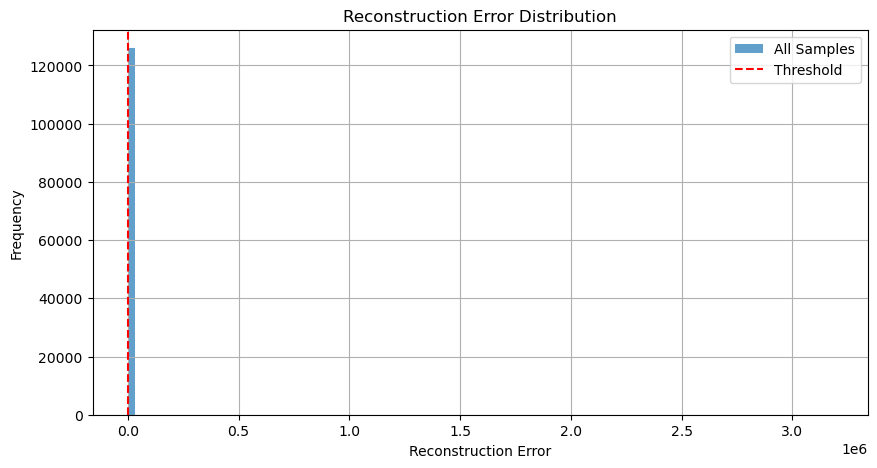

In [16]:
X_all = df.iloc[:, :-2].values
y_all = df['label'].values
X_all_scaled = scaler.transform(X_all)
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    reconstructed = model(X_all_tensor)
    reconstruction_errors = torch.mean((X_all_tensor - reconstructed) ** 2, dim=1).numpy()

# Set threshold for anomaly detection (set at 85 here, but can be optimized for best performance)
train_errors = []
with torch.no_grad():
    for x in KDDDataset(X_normal_scaled):
        train_errors.append(torch.mean((x - model(x))**2).item())

threshold = np.percentile(train_errors, 85)
print(f"Reconstruction error threshold: {threshold:.6f}")

# Prediction and evaluation
y_pred = (reconstruction_errors > threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(y_all, y_pred, target_names=["Normal", "Attack"]))

# Reconstruction visualization
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=100, alpha=0.7, label='All Samples')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.grid(True)
plt.show()


--- KDDTest+ Evaluation ---
              precision    recall  f1-score   support

      Normal       0.83      0.88      0.85      9711
      Attack       0.90      0.87      0.88     12833

    accuracy                           0.87     22544
   macro avg       0.87      0.87      0.87     22544
weighted avg       0.87      0.87      0.87     22544



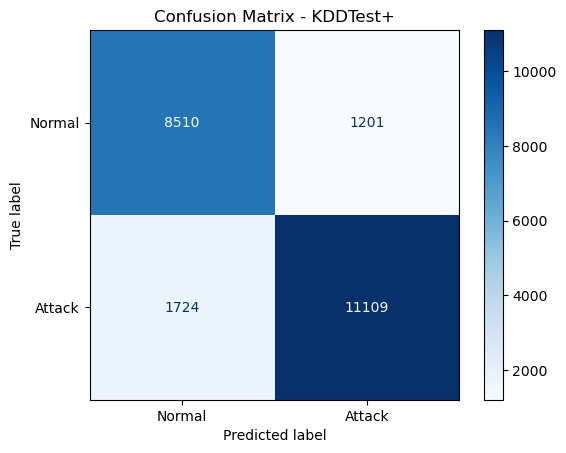

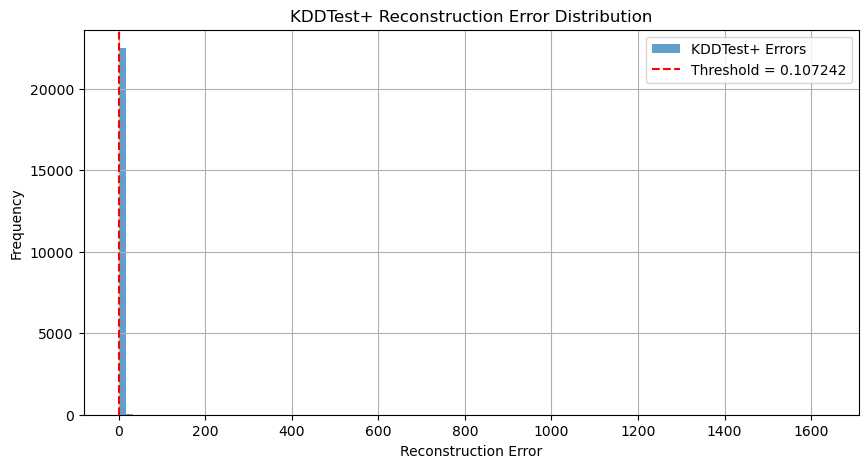

In [17]:
df_test = pd.read_csv("KDDTest+.txt", header=None, names=cols)

# Same encoding as performed during training
for col in ['feature_1', 'feature_2', 'feature_3']:
    df_test[col] = LabelEncoder().fit_transform(df_test[col])  # ideally reuse encoder from training

# --- Binary labels ---
df_test['label'] = df_test['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Extract features and resuse training scaler
X_test_raw = df_test.iloc[:, :-2].values
y_test = df_test['label'].values
X_test_scaled = scaler.transform(X_test_raw)  

# Run on test data
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
model.eval()

with torch.no_grad():
    reconstructed_test = model(X_test_tensor)
    test_errors = torch.mean((X_test_tensor - reconstructed_test) ** 2, dim=1).numpy()

# Reuse training threshold and classify
y_test_pred = (test_errors > threshold).astype(int)

# Performance evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n--- KDDTest+ Evaluation ---")
print(classification_report(y_test, y_test_pred, target_names=["Normal", "Attack"]))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - KDDTest+")
plt.grid(False)
plt.show()

# Reconstruction error plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(test_errors, bins=100, alpha=0.7, label="KDDTest+ Errors")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.6f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("KDDTest+ Reconstruction Error Distribution")
plt.legend()
plt.grid(True)
plt.show()

As can be seen here, the model performs much better than the MLP on unseen data, which is what is expected of it in real-world applications. The f1-score shows an accuracy of 88% compared to the 79% of the MLP. With further fine tuning of hyperparameters and more training epochs, this accuracy can be increased even further.